# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: DL Modell erstellen

Hier in diesem Notebook erstellen wir unsere Deep Learning Modelle.

# Libraries Importieren & GPU Check

In [1]:
# General Libraries
import logging
from datetime import datetime
import os
import random

# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# keras Libraries
from keras.utils import to_categorical

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# dataclass
import dataclasses
from dataclasses import dataclass

# general setup
tf.debugging.set_log_device_placement(False)

# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(
    level=logging.INFO, filename=f"{date_time_string}.txt", filemode="a"
)
print(tf.config.list_physical_devices())

# Num of Gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


# Daten einlesen

- Einlesen der **Getrimmten Daten**

In [2]:
# Static Parameters
@dataclass
class Parameters:
    batch_size: int = 64
    epochs: int = 20
    verbosity: str = "auto"
    number_folds: int = 6
    output_size: int = 6
    window_size = 400
    step_size = 10
    data_augmentation  = False
    

# Getrimmte Sensordaten einlesen
df = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/Alle_Messungen_trimmed.csv", index_col=0)
display(df)

# convert the string time column to datetime
epoch = pd.Timestamp("1970-01-01")

# Time column into datetime
df["time"] = pd.to_datetime(df["time"])

# Time column into milliseconds
df["time"] = (df["time"] - epoch).apply(lambda x: int(x.total_seconds() * 1000))


,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
1,2023-02-27 15:02:17.156,0.000000,9.722000,1.278000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.217750,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,2023-02-27 15:02:31.574,-0.728000,9.779000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.420650,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,2023-02-27 15:02:16.685,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.500000,-13.143750,0.000000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,2023-02-27 15:02:32.295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.012501,0.000000,20.587502,0.000000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
5,2023-02-27 15:02:33.285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.612501,0.000000,20.268751,0.000000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539029,2023-03-11 13:11:56.901,2.507094,4.691251,-0.583939,0.246416,0.067954,0.365369,-4.043274,6.146469,44.221630,0.959304,-0.001751,0.282337,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...
2539030,2023-03-11 13:11:56.911,1.888469,3.766656,-0.826295,0.196101,0.019053,0.352243,-3.925354,6.195618,44.229263,0.959236,-0.003181,0.282578,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...
2539031,2023-03-11 13:11:56.921,0.994240,3.075035,-0.740944,0.105015,-0.027495,0.306060,-3.801758,6.023056,43.900330,0.959244,-0.004561,0.282538,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...
2539032,2023-03-11 13:11:56.931,0.423654,2.433349,-0.432823,-0.027677,0.027132,0.250502,-3.830048,6.086670,43.879021,0.959245,-0.005843,0.282515,9_iphone13mini-2023-03-11_13-09-56,Weiping_Zhang,Velofahren,9_iphone13mini-2023-03-11_13-09-56Weiping_Zhan...


# Preprocessing Data

- Beim Preprocessing entfernen von drei zufällige Sensor Messungen aus unserem Datensatz  
- Validierungsdatensatz daraus erstellen, der verwendet wird, um das Modell zu validieren
- Nicht relevante Spalten löschen
- Funktion für *augment_data* erstellen, um Daten zu erweitern
- Transformation der Daten in passende Window Size mit Step Size für das DL-Modell


## Create Validation Data

In [3]:
# select three random id_combines files
ids = ["06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren", 
       "01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen", 
       "01_iPhone13ProMax-2023-03-15_18-29-42Gabriel_TorresRennen",
       "04_SamsungA22-2023-02-27_17-53-45Ben_TranSitzen",
       "03_Huawei_Stehen-2023-03-16_15-27-54Lea_BuetlerStehen",
       "01_iPhone14Pro_2023-02-28_20-09-53Yvo_KellerTreppenlaufen"]

# create a dataframe with these three random files
df_validation = df[df["id_combined"].isin(ids)]

# export the dataframe as a csv file
df_validation.to_csv("data/validation-data.csv", index=False)

# remove the validation data from the dataframe 
df = df[~df["id_combined"].isin(ids)]

## Drop unnötige Spalten und Class Encoden

In [4]:
# drop the columns that are not needed
df = df.drop(columns=["id", "user", "id_combined"])
# get all types of the df
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])
# print dictionary of the classes and its encoded values
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Laufen': 0, 'Rennen': 1, 'Sitzen': 2, 'Stehen': 3, 'Treppenlaufen': 4, 'Velofahren': 5}


## Daten Transformation

In [5]:
# Create function to add noise to time series
def add_noise(time_series, noise_factor):
    noise = np.random.randn(len(time_series)) * noise_factor
    return time_series + noise

# Flip time series
def flip_time_series(time_series):
    return np.flip(time_series)

# Scale magnitude
def scale_magnitude(time_series, scaling_factor):
    return time_series * scaling_factor

# Augment the data
def augment_data(X, y, noise_factor, scaling_factor, flip_probability):
    augmented_X = []
    augmented_y = []
    for i in range(X.shape[0]):
        x_sample = X[i]
        y_sample = y[i]

        # Add noise
        x_sample_noisy = add_noise(x_sample, noise_factor)
        augmented_X.append(x_sample_noisy)
        augmented_y.append(y_sample)

        # Scale magnitude
        x_sample_scaled = scale_magnitude(x_sample, scaling_factor)
        augmented_X.append(x_sample_scaled)
        augmented_y.append(y_sample)

        # Flip time series
        if random.random() < flip_probability:
            x_sample_flipped = flip_time_series(x_sample)
            augmented_X.append(x_sample_flipped)
            augmented_y.append(y_sample)

    return np.array(augmented_X), np.array(augmented_y)

In [6]:
# Define a custom data generator using tf.keras.utils.Sequence
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = self.x_data[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y_data[idx * self.batch_size : (idx + 1) * self.batch_size]
        return batch_x, batch_y

In [7]:
# set the window size and step size parameters
window_size = Parameters.window_size
step_size = Parameters.step_size

# select the features and labels
X = df.values[:, 1:13]
y = df["class"].values

# emtpy lists for the windows and labels
X_windows = []
y_windows = []

# create if statement for data augmentation
if Parameters.data_augmentation:
    noise_factor = 0.1
    scaling_factor = 1.5
    flip_probability = 0.5

    # Augment the data
    X_augmented, y_augmented = augment_data(X, y, noise_factor, scaling_factor, flip_probability)
    
    augmented_i = 0
    i = 0
    while augmented_i + window_size <= X_augmented.shape[0]:
        window_data = X_augmented[augmented_i : augmented_i + window_size, :]
        window_labels = y_augmented[augmented_i : augmented_i + window_size]
        
        # Check if there is an activity transition within the window
        if len(np.unique(window_labels)) == 1:
            X_windows.append(window_data)
            y_windows.append(window_labels[0])
            
        augmented_i += step_size
        i += step_size
# if no data augmentation is needed
else:
    i = 0
    while i + window_size <= X.shape[0]:
        window_data = X[i : i + window_size, :]
        window_labels = y[i : i + window_size]
        
        # Check if there is an activity transition within the window
        if len(np.unique(window_labels)) == 1:
            X_windows.append(window_data)
            y_windows.append(window_labels[0])
            
        i += step_size

X_windows = np.array(X_windows)
# Update timesteps value
timesteps = X_windows.shape[1]  
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)
y_windows = to_categorical(y_windows, num_classes=6)

# Split the dataset into training and testing sets
x_train, x_validation, y_train, y_validation = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows
)

# Create data generators
train_generator = DataGenerator(x_train, y_train, batch_size=Parameters.batch_size)
validation_generator = DataGenerator(x_validation, y_validation, batch_size=Parameters.batch_size)

# print Data shapes
print("Data shapes:")
print("- x:         = {}".format(X.shape))
print("- y:         = {}".format(y.shape))
print("- x_train:   = {}".format(x_train.shape))
print("- y_train:   = {}".format(y_train.shape))
print("- x_validation:    = {}".format(x_validation.shape))
print("- y_validation:    = {}".format(y_validation.shape))

Data shapes:
- x:         = (2301126, 12)
- y:         = (2301126,)
- x_train:   = (183898, 400, 12)
- y_train:   = (183898, 6)
- x_validation:    = (45975, 400, 12)
- y_validation:    = (45975, 6)


# DL-Modelle erstellen

- DL Modelle mit Tensorflow Framework erstellt 

Tabellarische Auflistung aller DL-Modelle und deren Parameter

| DL-Modell | Anzahl CNN Layer | CNN Filter Size | Kernel Size | Aktivierungsfunktion | L2-Regularisierung | Dropout | Anzahl LSTM Layer | LSTM Neuronen | Anzahl Dense Layer | Dense Neuronen | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 01 | 1 | 64 | 2 | relu | 0.01 | - | 1 | 100 | 1 | 6 | 
| 02 | 1 | 64 | 4 | relu | 0.01 | 0.2 | 1 | 100 | 1 | 6 |  
| 03 | 1 | 32 | 2 | relu | 0.01 | - | 1 | 100 | 1 | 6 | 
| 04 | 1 | 64 | 2 | relu | 0.01 | - | 1 | 100 | 1 | 6 | 
| 05 | 3 | (32,20,10) | 2 | relu | 0.01 | - | - | - | 3 | (180,100,6) | 
| 06 | 2 | (64,32) | 2 | relu | 0.01 | - | - | - | 4 | (200,100,50,6) | 
| 07 | 5 | (64,64,64,64,64) | 2 | relu | 0.05 | - | - | - | 6 | (200,150,100,50,25,6)

In [8]:
# Creating Deep Learning Models

# First Deep Learning Model - CNN - LSTM
def create_model_1(name="model_1"):
    '''
    CNN Model with 1 Convolutional Layer, 1 LSTM Layer and 1 Dense Layer 
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=12,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# Second Deep Learning Model - CNN - LSTM
def create_model_2(name="model_2"):
    '''
    CNN Model with one Conv1D layer, one LSTM layer and one Dense layer, also using l2 regularization and dropout
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=16,
                kernel_size=4,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
            tf.keras.layers.Dropout(0.2),

            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# Thrid Deep Learning Model - CNN - LSTM
def create_model_3(name="model_3"):
    '''
    CNN Model with 32 Filters combine with LSTM and one dense layer
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# Fourth Deep Learning Model - CNN - LSTM
def create_model_4(name="model_4"):
    '''
    CNN Model with 64 Filters combined with LSTM and one dense layer
    '''
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# Fifth Deep Learning Model - CNN - MLP
def create_model_5(name="model_5"):
    '''
    CNN Model with 3 Conv1D Layers and 3 Dense Layers with Batch Normalization and L2 Regularization
    '''
    model = tf.keras.Sequential(
        [
            # First Conv1D layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Batch Normalization and MaxPooling 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Second Conv1D layer
            tf.keras.layers.Conv1D(
                filters=20, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Batch Normalization and MaxPooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Third Conv1D layer
            tf.keras.layers.Conv1D(
                filters=10, 
                kernel_size=2, 
                activation="relu", 
                padding="same", 
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Batch Normalization and MaxPooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Flatten output
            tf.keras.layers.Flatten(),
            # Add first dense layer
            tf.keras.layers.Dense(units = 180, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            # Batch Normalization
            tf.keras.layers.BatchNormalization(),
            # Add second dense layer
            tf.keras.layers.Dense(units = 100, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            # Batch Normalization
            tf.keras.layers.BatchNormalization(),
            # Add third dense layer - Output Layer with softmax activation
            tf.keras.layers.Dense(6, activation="softmax"),
        ],
        name=name,
    )

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# Sixth Deep Learning Model - CNN - MLP
def create_model_6(name="model_6", 
                   filterconv1 = 64, 
                   filterconv2 = 32, 
                   unitsdense1 = 200, 
                   unitsdense2 = 100, 
                   unitsdense3 = 50, 
                   l2_reg = 0.01):
    '''
    CNN Model with 2 Conv1D Layers and 4 Dense Layers with Batch Normalization and L2 Regularization
    '''
    model = tf.keras.Sequential(
        [
            # First Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv1,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Second Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv2, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Flatten the results
            tf.keras.layers.Flatten(),
            # Add first dense layer
            tf.keras.layers.Dense(units = unitsdense1, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add second dense layer
            tf.keras.layers.Dense(units = unitsdense2, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add third dense layer
            tf.keras.layers.Dense(units = unitsdense3, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add output Layer with Softmax Activation Funktion
            tf.keras.layers.Dense(units = 6, 
                                  activation="softmax"),
        ],
        name=name,
    )
    # Define optimizer, loss and metrics 
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# Seventh Deep Learning Model - CNN - MLP
def create_model_7(name="model_7", 
                   filterconv1 = 64, 
                   filterconv2 = 64, 
                   filterconv3 = 64, 
                   filterconv4 = 64,
                   filterconv5 = 64, 
                   unitsdense1 = 200, 
                   unitsdense2 = 150, 
                   unitsdense3 = 100,
                   unitsdense4 = 50,
                   unitsdense5 = 25,
                   l2_reg = 0.05):
    '''
    Check, if the deeper the model the better the results? 
    CNN Model with 5 Conv1D Layers and 6 Dense Layers with Batch Normalization and L2 Regularization
    '''
    model = tf.keras.Sequential(
        [
            # First Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv1,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Second Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv2, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Third Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv3, 
                kernel_size=2, 
                activation="relu", 
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Fourth Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv4,
                kernel_size=2,
                activation="relu",
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Fifth Conv1D Layer
            tf.keras.layers.Conv1D(
                filters=filterconv5,
                kernel_size=2,
                activation="relu",
                padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            ),
            # Batchnormalization and Maxpooling
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # Flatten the results
            tf.keras.layers.Flatten(),
            # Add first dense layer
            tf.keras.layers.Dense(units = unitsdense1, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add second dense layer
            tf.keras.layers.Dense(units = unitsdense2, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add third dense layer
            tf.keras.layers.Dense(units = unitsdense3, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # Add fourth dense layer
            tf.keras.layers.Dense(units = unitsdense4,
                                  activation="relu",
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
            # add fifth dense layer
            tf.keras.layers.Dense(units = unitsdense5,
                                  activation="relu",
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg),),
            tf.keras.layers.BatchNormalization(),
        
            # Add output Layer with Softmax Activation Funktion
            tf.keras.layers.Dense(units = 6, 
                                  activation="softmax"),
        ],
        name=name,
    )
    # Define optimizer, loss and metrics 
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


# DL-Modelle Trainieren

In [9]:
# Keep track of the best model's history
best_model_history = None  
model_histories = []

# Perform training and validation
models = [create_model_1,create_model_2,create_model_3,create_model_4,create_model_5,create_model_6,create_model_7]
best_model = None
best_model_acc = 0

# start training
for j, model_creator in enumerate(models):
    print(f"Model {model_creator.__name__}")
    model_name = f"Model_{j+1}"
    model = model_creator(name=model_name)
    logging.info(f"Model {j+1}")
    history = model.fit(
        train_generator,
        epochs=Parameters.epochs,
        batch_size=Parameters.batch_size,
        validation_data=validation_generator,
        verbose=Parameters.verbosity,
    )
    test_loss, acc, prec, recal = model.evaluate(
        x_validation, y_validation, verbose=Parameters.verbosity
    )
    logging.info(f"Validation accuracy: {acc}")

    model_histories.append(history.history)

    for epoch in range(Parameters.epochs):
        # Log accuracy after each epoch
        acc_epoch = history.history["val_accuracy"][epoch]
        logging.info(f"Epoch {epoch + 1}, Validation accuracy: {acc_epoch}")

    if best_model_history is None or acc > best_model_acc:
        best_model_history = history
        # Store the trained model instance
        best_model = model  
        best_model_acc = acc
    
    # Save the model
    model.save(f'saved_model/sensor_model/{model_creator.__name__}.h5')

print(best_model.name)


Model create_model_1
Epoch 1/20
2874/2874 [==============================] - 109s 36ms/step - loss: 0.3815 - accuracy: 0.9076 - precision: 0.9361 - recall: 0.8765 - val_loss: 0.3242 - val_accuracy: 0.8946 - val_precision: 0.9015 - val_recall: 0.8875
Epoch 2/20
2874/2874 [==============================] - 100s 35ms/step - loss: 0.2194 - accuracy: 0.9526 - precision: 0.9577 - recall: 0.9481 - val_loss: 0.1684 - val_accuracy: 0.9640 - val_precision: 0.9679 - val_recall: 0.9612
Epoch 3/20
2874/2874 [==============================] - 98s 34ms/step - loss: 0.1778 - accuracy: 0.9596 - precision: 0.9629 - recall: 0.9567 - val_loss: 0.1668 - val_accuracy: 0.9626 - val_precision: 0.9650 - val_recall: 0.9611
Epoch 4/20
2874/2874 [==============================] - 100s 35ms/step - loss: 0.1893 - accuracy: 0.9554 - precision: 0.9597 - recall: 0.9516 - val_loss: 0.1327 - val_accuracy: 0.9724 - val_precision: 0.9767 - val_recall: 0.9692
Epoch 5/20
2874/2874 [==============================] - 100s 35m

# Alle Modell Einlesen und predicten um bestes Modell anhand unseen Data 

In [17]:
# create class for validation data of unseen data
# import label encoder as le
class validate_unseen_data():
    def __init__(self, model_path="saved_model/sensor_model.h5"):
        self.model = tf.keras.models.load_model(model_path)
        self.csv_path = "data/validation-data.csv"
        
    
    def predict_classes(self, file="06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren", expected=1.0):
        df_val = pd.read_csv(self.csv_path)
        # Filter the rows where its velo in id_combined
        df_val = df_val[df_val["id_combined"].str.contains(file)]
        df_val = df_val.drop(columns=["id", "user", "id_combined"])
        # convert the string time column to datetime
        epoch = pd.Timestamp("1970-01-01")
        df_val["time"] = pd.to_datetime(df_val["time"])
        df_val["time"] = (df_val["time"] - epoch).apply(
            lambda x: int(x.total_seconds() * 1000)
        )
        # get all types of the df
        le = LabelEncoder()
        df_val["class"] = le.fit_transform(df_val["class"])
    
        # Set the window size and step size
        window_size = 400
        step_size = 10

        # Reshape X to 2D format (samples, features)
        X = df_val.values[:, 1:13]
        # X to textfile

        # print X in a loop and in a valid Python Array Format and comma seperated array values
        
        
        # write textfile with the X data in the following format [X1

        # Create a sliding window of X with the specified window and step sizes
        X_windows = np.array(
            [
                X[i : i + window_size, :]
                for i in range(0, X.shape[0] - window_size + 1, step_size)
            ]
        )

        # Reshape X_windows to 3D format (samples, timesteps, features)
        timesteps = X_windows.shape[1]
        n_features = X_windows.shape[2]
        X_windows = X_windows.reshape(-1, timesteps, n_features)

        y_pred_probs = self.model.predict(X_windows)

        # Get the predicted class labels for each input window
        y_pred_labels = np.argmax(y_pred_probs, axis=1)

        # Print the predicted class labels
        # get the median of the predicted labels
        sol = np.median(y_pred_labels)
        # caluclate the most frequent class not the median
        sol = np.bincount(y_pred_labels).argmax()
        print(f'has classified: {sol}')
        print(f'was {expected}')

        class_counts = np.bincount(y_pred_labels)
        for i, count in enumerate(class_counts):
            print(f"Class {i} count: {count}")
        
        return (sol, expected)

import glob

path = "saved_model/sensor_model/*.h5"
h5_files = glob.glob(path)
print(h5_files)

best_model = None
lowest_difference = float('inf')
most_correct = 0


for h5_file in h5_files:
    model_name = h5_file.split("/")[-1]
    print(f"Model name: {model_name}")
    
    # Load the model
    model = validate_unseen_data(h5_file)
    
    # Calculate the differences
    median1 = model.predict_classes('06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren', 5)[0]
    median2 = model.predict_classes('01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen', 0)[0]
    median4 = model.predict_classes('01_iPhone13ProMax-2023-03-15_18-29-42Gabriel_TorresRennen', 1)[0]
    median5 = model.predict_classes("03_Huawei_Stehen-2023-03-16_15-27-54Lea_BuetlerStehen", 3)[0]
    median6 = model.predict_classes("01_iPhone14Pro_2023-02-28_20-09-53Yvo_KellerTreppenlaufen", 4)[0]

    correctness = [
        int(median1 == 5.0),
        int(median2 == 0.0),
        int(median4 == 1.0),
        int(median5 == 3.0),
        int(median6 == 4.0)
    ]

    total_correct = sum(correctness)
    print(f"Total correct: {total_correct}")

# Check if the current model has the most correct predictions
    if total_correct > most_correct:
        most_correct = total_correct
        best_model = model_name

print("Best model:", best_model)
import os

best_model_name = os.path.basename(best_model)
best_model_path = os.path.join("saved_model", "sensor_model", best_model_name)
best_model = tf.keras.models.load_model(best_model_path)




['saved_model/sensor_model\\create_model_1.h5', 'saved_model/sensor_model\\create_model_2.h5', 'saved_model/sensor_model\\create_model_3.h5', 'saved_model/sensor_model\\create_model_4.h5', 'saved_model/sensor_model\\create_model_5.h5', 'saved_model/sensor_model\\create_model_6.h5', 'saved_model/sensor_model\\create_model_7.h5']
Model name: sensor_model\create_model_1.h5
18/18 [==============================] - 1s 27ms/step
has classified: 5
was 5
Class 0 count: 0
Class 1 count: 0
Class 2 count: 0
Class 3 count: 0
Class 4 count: 0
Class 5 count: 547
20/20 [==============================] - 0s 12ms/step
has classified: 0
was 0
Class 0 count: 326
Class 1 count: 0
Class 2 count: 0
Class 3 count: 8
Class 4 count: 302
Class 5 count: 2
78/78 [==============================] - 1s 13ms/step
has classified: 4
was 1
Class 0 count: 1034
Class 1 count: 9
Class 2 count: 3
Class 3 count: 57
Class 4 count: 1363
2/2 [==============================] - 0s 10ms/step
has classified: 3
was 3
Class 0 count: 

## Loss und Accuracy Verlauf vom besten Modell

Model_1


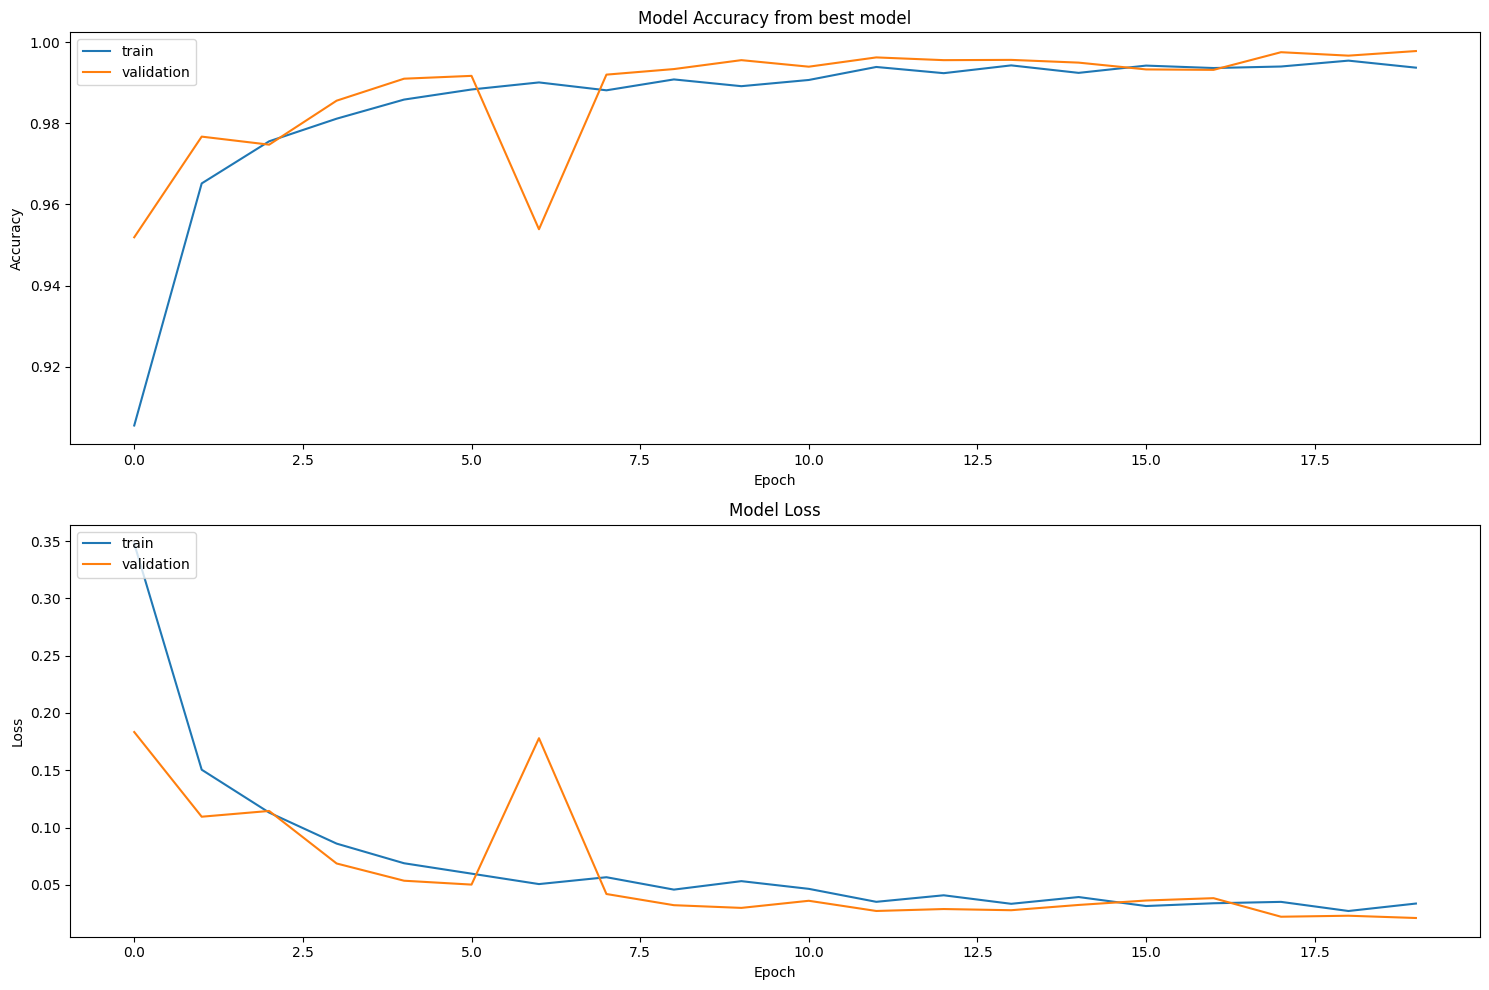

In [11]:
print(best_model.name)

# Create 2 subplots one for model accuracy and another for model loss
fig, axs = plt.subplots(2, figsize=(15, 10))
# Summarize history for accuracy
axs[0].plot(best_model_history.history["accuracy"])
axs[0].plot(best_model_history.history["val_accuracy"])
axs[0].set_title("Model Accuracy from best model")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")  
axs[0].legend(["train", "validation"], loc="upper left")
# Summarize history for loss
axs[1].plot(best_model_history.history["loss"])
axs[1].plot(best_model_history.history["val_loss"])
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].legend(["train", "validation"], loc="upper left")
plt.tight_layout()
plt.show()

## Confusions Matrix

5747/5747 [==============================] - 57s 10ms/step


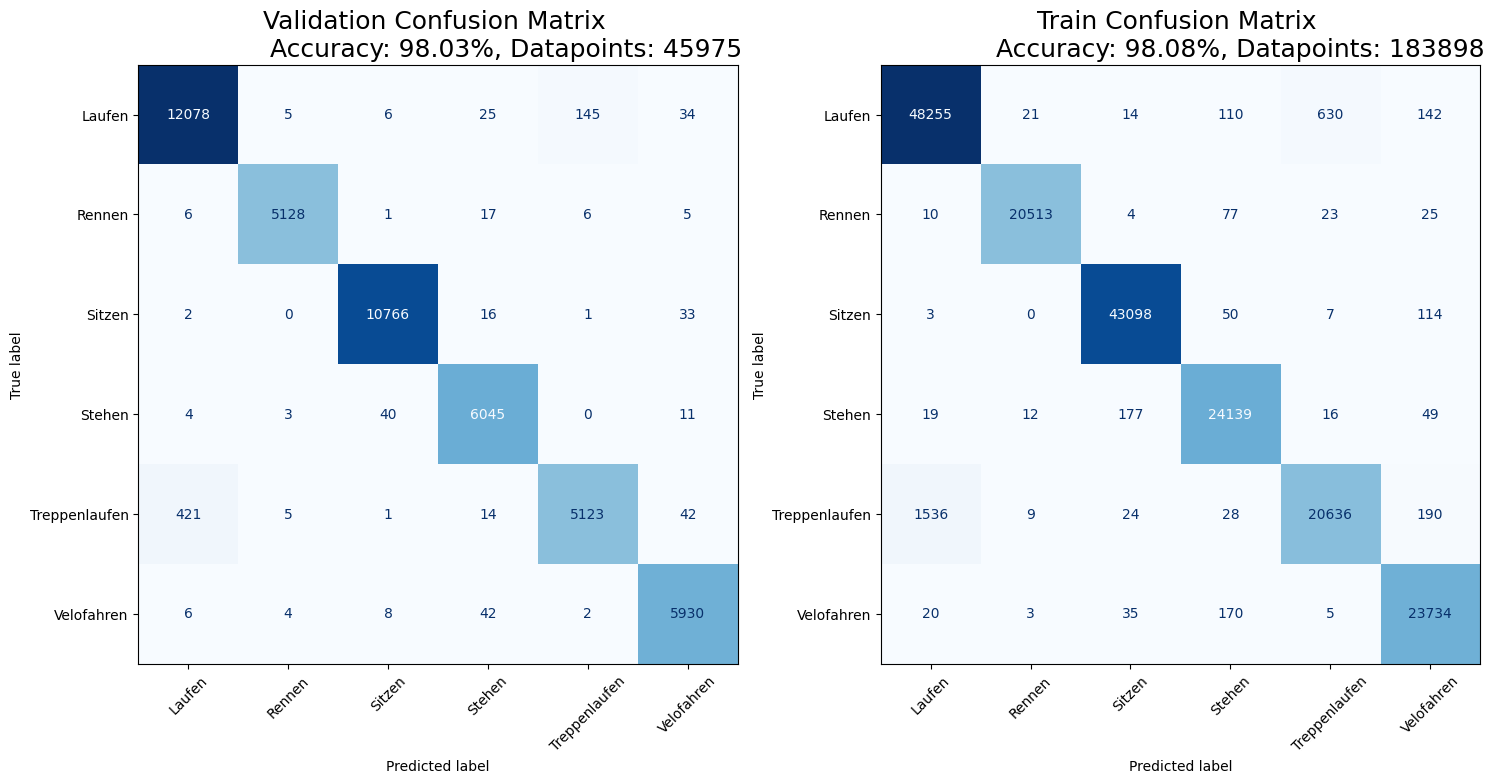

In [12]:
# Create for x_train and x_test confusion matrix
y_pred = best_model.predict(x_validation)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_validation, axis=1)
accuracy = accuracy_score(y_true = y_test_labels, y_pred = y_pred_labels)

cm = confusion_matrix(y_true = y_test_labels, y_pred = y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create subplot for test confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
disp.plot(cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Validation Confusion Matrix \n \
                Accuracy: {:.2f}%, Datapoints: {}".format(accuracy * 100, x_validation.shape[0]), fontsize=18)
ax1.set_xticklabels(le.classes_, rotation=45)

# Create for x_train and x_test confusion matrix
y_pred = best_model.predict(x_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

accuracy = accuracy_score(y_true = y_train_labels, y_pred = y_pred_labels)
cm = confusion_matrix(y_true = y_train_labels, y_pred = y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Create subplot for train confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax2, colorbar=False)
# add to title number of observations
ax2.set_title("Train Confusion Matrix \n \
              Accuracy: {:.2f}%, Datapoints: {}".format(accuracy * 100, x_train.shape[0]), fontsize=18)
ax2.set_xticklabels(le.classes_, rotation=45)

plt.tight_layout()
plt.show()


# Export bestes DL-Modell

In [13]:
# export Model to json Tensorflow file for JS Frontend
import json

best_model.save("saved_model/sensor_model.h5")